Filename: EP240219a_n9.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  EBOUNDS       1 BinTableHDU     51   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     38   4098617R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     39   1R x 2C   [1D, 1D]   
1468.5


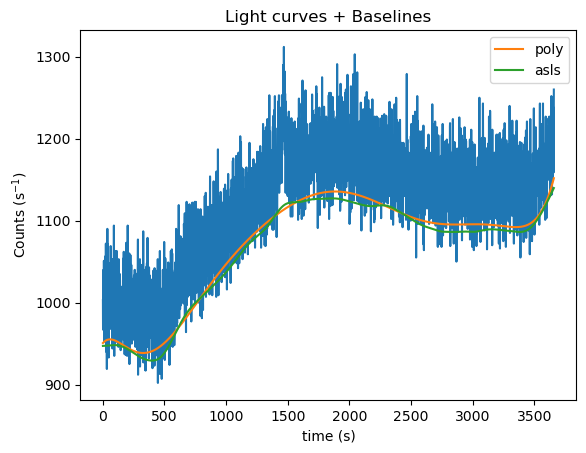

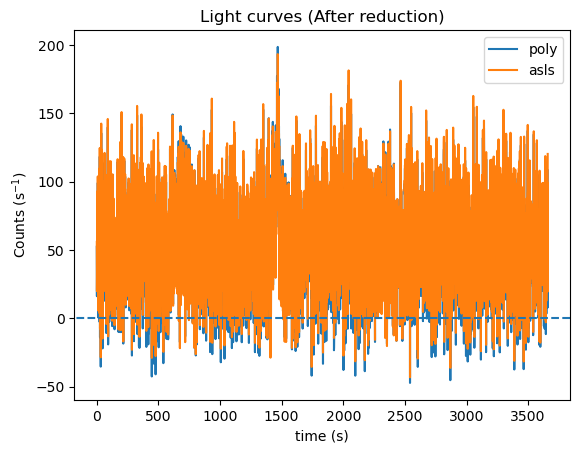

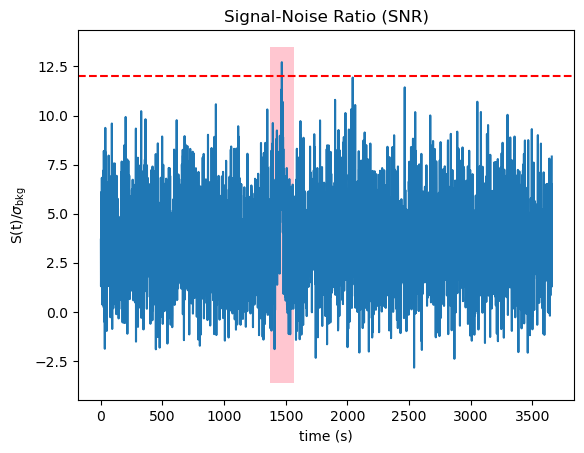

In [8]:
import numpy as np
from astropy.io import fits
from pybaselines import Baseline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


filename = 'EP240219a_n9.fit'
hdul = fits.open(filename)
hdul.info(sys.stdout)
# hdul[0].header
# hdul[1].header
with hdul as hdul_list:
    # Header information
    start_time = hdul[0].header.get('TSTART')
    end_time = hdul[0].header.get('TSTOP')
    # Read good time interval
    gti_data = hdul_list['GTI'].data
    gti_start = gti_data['START'][0]
    gti_end = gti_data['STOP'][0]
    # energy channels
    ebds_data = hdul_list['EBOUNDS'].data
    ebds_min = ebds_data['E_MIN']  # minimum energy for channels (128)
    ebds_max = ebds_data['E_MAX']  # maximum energy for channels
    channl_idx = np.arange(len(ebds_min))  # give channel index
    # read event data
    events_data = hdul_list['EVENTS'].data
    # print(hdul_list['EVENTS'].header)
    ph_times = events_data['TIME']
    # print(hdul_list['EVENTS'].header)
    ph_chnnls = events_data['PHA']
    # get valid energy channels
    E_targetmin = 1
    E_targetmax = 2000
    # valid channel index
    valid_chnnl_idx = (ebds_min >= E_targetmin) & (ebds_max <= E_targetmax)
    valid_chnnls = channl_idx[valid_chnnl_idx]

    # select target range
    valid_time_idx = (ph_times >= gti_start) & (ph_times <= gti_end)
    valid_ene_idx = np.isin(ph_chnnls, valid_chnnls)
    valid_time_idx_all = valid_time_idx & valid_ene_idx
    ph_times = ph_times[valid_time_idx_all]
    ph_chnnls = ph_chnnls[valid_time_idx_all]

# give light curves
bin_size = 1  # s
rel_times = ph_times - gti_start
t_min = np.percentile(rel_times, 0.00)
t_max = np.percentile(rel_times, 100.00)
bins = np.arange(t_min, t_max, bin_size)
time_centers = (bins[:-1] + bins[1:]) / 2  # time sequence
time_counts, _ = np.histogram(rel_times, bins=bins)  # photon counts
time_counts = time_counts/bin_size

baseline_fitter = Baseline(time_centers)
bkg_1, params_1 = baseline_fitter.modpoly(time_counts, poly_order=10)
bkg_2, params_2 = baseline_fitter.asls(time_counts, lam=1e6)
# bkg_3, params_3 = baseline_fitter.mor(time_counts, half_window = 5)

N_snr = 12
bkg = bkg_2
net_counts = time_counts - bkg
# identify background region
pure_bkg_idx = (np.abs(net_counts) < np.std(net_counts))
bkg_sigma = np.std(net_counts[pure_bkg_idx])  # background sigma
snr = net_counts / (bkg_sigma + 1e-6)
up_idx = np.argmax(N_snr * snr)
print(time_centers[up_idx])
peaks, properties = find_peaks(snr, height=N_snr, distance=1)
peak_time = time_centers[peaks][0]

plt.figure()
plt.title('Light curves + Baselines')
plt.plot(time_centers, time_counts)
plt.plot(time_centers, bkg_1, label="poly")
plt.plot(time_centers, bkg_2, label="asls")
plt.xlabel('time (s)')
plt.ylabel(r'Counts ($\rm s^{-1}$)')
plt.legend()
plt.show()
# plt.plot(time_centers, N_snr * snr, label="SNR")
plt.figure()
plt.title('Light curves (After reduction)')
plt.plot(time_centers, time_counts - bkg_1, label='poly')
plt.plot(time_centers, time_counts - bkg_2, label='asls')
plt.axhline(0, 1, 0, linestyle='--')
plt.xlabel('time (s)')
plt.ylabel(r'Counts ($\rm s^{-1}$)')
# plt.plot(time_centers, bkg_3, label = 'mor')
plt.legend()
plt.show()
plt.figure()
plt.title('Signal-Noise Ratio (SNR)')
plt.plot(time_centers, snr)
x_shade = [peak_time - 100, peak_time + 100]
y_min, y_max = plt.gca().get_ylim()
plt.fill_between(x_shade, y_min, y_max, facecolor='pink', alpha=0.9, label='peak region')
plt.xlabel('time (s)')
plt.ylabel(r'S(t)/$\sigma_{\rm bkg}$')
plt.axhline(12,  linestyle='--', color='red') 
plt.show()